In [53]:
import import_ipynb


In [54]:
import cdp_agent
from cdp_agent import *

In [55]:
from langchain_core.messages import HumanMessage, SystemMessage


messages = [HumanMessage(content="What tasks can you do")]
messages = cdp_graph.invoke({"messages": messages},config,stream_mode="values")

# messages["messages"][-2:]

for m in messages["messages"][-2:]:
    m.pretty_print()

================================ Human Message =================================

What tasks can you do
================================== Ai Message ==================================

My capabilities are solely determined by the `default_api` library.  I can execute a range of tasks related to managing cryptocurrencies, NFTs, and interacting with specific DeFi protocols.  These include:

**1. Token and NFT Handling:**

* **Deployment:**  I can deploy new ERC-20 tokens (requiring name, symbol, and total supply) and ERC-721 NFT collections (requiring name, symbol, and base URI).
* **Transfers:** I can transfer various assets, including ETH, USDC, other ERC-20 tokens, and ERC-721 NFTs between addresses.  Gasless transfers are utilized where supported by the `default_api` (e.g., USDC on Base).
* **Balance Retrieval:** I can obtain balance information for ETH, USDC, other ERC-20 tokens, and NFT holdings for a given contract.
* **NFT Minting:** I can mint new NFTs from an existing ERC-721 

In [56]:
import arcade_agent
from arcade_agent import *

In [57]:
from langchain_core.messages import HumanMessage, SystemMessage



messages = [HumanMessage(content="What tasks can you perform")]
messages = arcadeai_agent.invoke({"messages": messages},config,stream_mode="values")

# messages["messages"][-2:]

for m in messages["messages"][-2:]:
    m.pretty_print()

================================ Human Message =================================

What tasks can you perform
================================== Ai Message ==================================

I can perform various tasks related to X (formerly Twitter).  I can look up users by their username, search for recent tweets by keywords or username, look up tweets by ID, post tweets, and delete tweets.


In [58]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["blockchain_agent", "twitter_agent"]

options = members + ["FINISH"]


system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

from pydantic import BaseModel
class Router(BaseModel):
    next: Literal["blockchain_agent", "twitter_agent", "FINISH"]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

class State(MessagesState):
    next: str

# def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
#     messages = [
#         {"role": "system", "content": system_prompt},
#     ] + state["messages"]
#     response = llm.with_structured_output(Router).invoke(messages)
#     goto = response["next"]
#     if goto == "FINISH":
#         goto = END

#     return Command(goto=goto, update={"next": goto})

# In the supervisor_node definition:
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        SystemMessage(content=system_prompt),  # Changed from dict to SystemMessage
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END
    return Command(goto=goto, update={"next": goto})





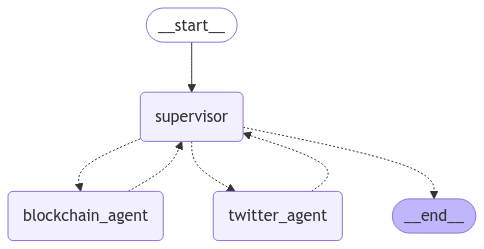

In [59]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


def blockchain_node(state: State) -> Command[Literal["supervisor"]]:
    result = cdp_graph.invoke(state.messages)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="blockchain_agent")
            ]
        },
        goto="supervisor",
    )


def twitter_node(state: State) -> Command[Literal["supervisor"]]:
    result = arcadeai_agent.invoke(state.messages)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="twitter_agent")
            ]
        },
        goto="supervisor",
    )



builder_multiagent = StateGraph(State)
builder_multiagent.add_edge(START, "supervisor")
builder_multiagent.add_node("supervisor", supervisor_node)
builder_multiagent.add_node("blockchain_agent", blockchain_node)
builder_multiagent.add_node("twitter_agent", twitter_node)

graph = builder_multiagent.compile()


from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [60]:
for s in graph.stream(
    {"messages": [("user", "Post Hello World on Twitter")]}, subgraphs=True
):
    print(s)
    print("----")

ValueError: no signature found for builtin type <class 'dict'>

<bound method Pregel.get_state of <langgraph.graph.state.CompiledStateGraph object at 0x00000260EEC8A780>>